<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/03-Deep-Learning/notebooks/Tarea-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulo 1 - Tarea 1

##Benítez Pineda Andrea

Construir un clasificador MLP para predecir la clase de un documento de texto del corpus *20newsgroups* ([más información](http://qwone.com/~jason/20Newsgroups/)), el cual ya ha sido usado varias veces en clase.

Para esto, puedes usar tantas capas como desees, además, puedes modificar el número de neuronas, hacer dropout, usar callbacks y gridsearch (puede ser muy tardado). También podrías aplicar reducción de dimensionalidad a alguna de las matrices de features obtenidas. La función de perdida para la clasificación multiclase que usaremos es `categorical_crossentropy` y la métrica de rendimiento será el accuracy.

Una vez que tengas tu mejor modelo posible respecto al accuracy, reportar también las métricas:

* Recall
* Precision
* Roc-Auc score
* La matriz de confusión

Divide el conjunto de datos en 85% de entrenamiento y 15% de prueba.

**Fecha de entrega: Domingo 25 de junio**

En el siguiente link puedes encontrar las mejores accuracy que se han logrado, así como la estrategia. https://paperswithcode.com/sota/text-classification-on-20news

No es realista esperar obtener resultados de ese orden puesto que se trata de un problema no trivial. En sesiones posteriores iremos mejorando este resultado con algunas redes más especializadas.

## 1. Obtener el dataset

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

full_data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'),
                               subset='all'
                              )


docs = full_data.data   # Los documentos
y = full_data.target    # Las clases de los documentos

Recuerda que para hacer clasificación multiclase con redes MLP necesitas tener las clases codificadas como *one-hot encoding*.

## 2. Obtención de features

Para obtener las features de cada documento usaremos dos estrategias:

1. El módelo bolsa de palabras (*Bag of words: BOW*). Para esto usaremos la clase `CountVectorizer` de scikit-learn.
2. El módelo TF-IDF. Para esto usaremos la clase `TfidfVectorizer` de scikit-learn. Los detalles de este modelo los puedes ver en la notebook de [clustering](https://github.com/DCDPUAEM/DCDP/blob/main/02-Machine-Learning/notebooks/12-Clustering.ipynb) del módulo pasado.

Además, limpiaremos el texto y lematizaremos.

> La lematización es un proceso lingüístico que consiste en, dada una forma flexionada (es decir, en plural, en femenino, conjugada, etc), hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra. Es decir, el lema de una palabra es la palabra que nos encontraríamos como entrada en un diccionario tradicional: singular para sustantivos, masculino singular para adjetivos, infinitivo para verbos. Por ejemplo, decir es el lema de dije, pero también de diré o dijéramos; guapo es el lema de guapas; mesa es el lema de mesas.



Bajamos las *stopwords*, signos de puntuación y el módulo *wordnet* (usado para sinónimos y lematización).

In [ ]:
import nltk
from nltk import download

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Limpiamos el texto quitando signos de puntuación, números, símbolos especiales y pasando todo a minúsculas. Usamos la función que ya habíamos definido en el módulo pasado.

In [ ]:
url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/02-Machine-Learning/data/limpiador_texto.py"
!wget --no-cache --backups=1 {url}

--2023-06-21 21:32:33--  https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/02-Machine-Learning/data/limpiador_texto.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 651 [text/plain]
Saving to: ‘limpiador_texto.py’

limpiador_texto.py  100%[===================>]     651  --.-KB/s    in 0s      

2023-06-21 21:32:34 (27.2 MB/s) - ‘limpiador_texto.py’ saved [651/651]



In [ ]:
from limpiador_texto import preprocesar_textos

clean_docs = preprocesar_textos(docs)

Veamos como va el corpus hasta el momento

In [ ]:
import pandas as pd

docs_df = pd.DataFrame(data={'document': clean_docs,
                             'class': y})
docs_df

,document,class
0,sure bashers pens fans pretty confused lack ki...,10
1,brother market highperformance video card supp...,3
2,finally said dream mediterranean new area grea...,17
3,think scsi card dma transfers disks scsi card ...,3
4,old jasmine drive use new system understanding...,4
...,...,...
18841,dn nyedacnsvaxuwecedu david nye dn neurology d...,13
18842,isolated ground recepticles usually unusual co...,12
18843,installed dx cpu clone motherboard tried mount...,3
18844,wouldnt require hypersphere space points speci...,1


Lematizamos

In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return(" ".join([lemmatizer.lemmatize(w,"v") for w in w_tokenizer.tokenize(text)]))

docs_df["lemmatized_document"] = docs_df['document'].apply(lemmatize_text)
docs_df

,document,class,lemmatized_document
0,sure bashers pens fans pretty confused lack ki...,10,sure bashers pen fan pretty confuse lack kind ...
1,brother market highperformance video card supp...,3,brother market highperformance video card supp...
2,finally said dream mediterranean new area grea...,17,finally say dream mediterranean new area great...
3,think scsi card dma transfers disks scsi card ...,3,think scsi card dma transfer disk scsi card dm...
4,old jasmine drive use new system understanding...,4,old jasmine drive use new system understand up...
...,...,...,...
18841,dn nyedacnsvaxuwecedu david nye dn neurology d...,13,dn nyedacnsvaxuwecedu david nye dn neurology d...
18842,isolated ground recepticles usually unusual co...,12,isolate grind recepticles usually unusual colo...
18843,installed dx cpu clone motherboard tried mount...,3,instal dx cpu clone motherboard try mount cpu ...
18844,wouldnt require hypersphere space points speci...,1,wouldnt require hypersphere space point specif...


Creamos una lista con los documentos preprocesados

In [ ]:
clean_docs = list(docs_df["lemmatized_document"].values)

## 3. El modelo



---



---


### 3.1  TF-IDF


---



---



Obtenemos la matriz de features TF-IDF. Recuerda que `topn_words` especifica cuántas palabras del vocabulario tomar, ordenadas por las más frecuentes.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

topn_words = 800

vectorizer = TfidfVectorizer(stop_words='english',
                             max_features=topn_words)
X_tfidf = vectorizer.fit_transform(clean_docs)
X_tfidf = np.asarray(X_tfidf.todense())
print(X_tfidf.shape)

(18846, 800)


Construimos un dataframe con la matriz de features

In [ ]:
X2 = pd.DataFrame(X_tfidf)

# Reordenamos las columnas, traemos la columna 'id' al principio
cols = X2.columns.tolist()
cols = cols[:]
X2= X2[cols]

print(X2.shape)
X2.head()

(18846, 800)


,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.141141,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.076871,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Realizamos codificación a **'y'**  con "one-hot" encoding

In [ ]:
y

array([10,  3, 17, ...,  3,  1,  7])

In [ ]:
Y = pd.get_dummies(data=y)
Y


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18841,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
18842,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
18843,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18844,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X2=X2.iloc[:,:].values
Y2=Y.iloc[:,:].values
print(X2.shape, Y2.shape)

(18846, 800) (18846, 20)


##División en conjuntos de entrenamiento y prueba

In [ ]:

from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,Y2,train_size=0.85,random_state=189)

print(f"Train size: {X_train2.shape[0]}")
print(f"Test size: {X_test2.shape[0]}")

Train size: 16019
Test size: 2827


##Reducción de dimensionalidad

In [ ]:
"""
from sklearn.feature_selection import SelectKBest, VarianceThreshold
selector = VarianceThreshold(0.25)
X_train1 = selector.fit_transform(X_train)
X_test1 = selector.transform(X_test)
"""

'\nfrom sklearn.feature_selection import SelectKBest, VarianceThreshold\nselector = VarianceThreshold(0.25)\nX_train1 = selector.fit_transform(X_train)\nX_test1 = selector.transform(X_test)\n'

##Normalizamos

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scl2 = scaler.fit_transform(X_train2)
X_test_scl2 = scaler.transform(X_test2)


##Construcción del modelo

In [ ]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical


In [ ]:
##Sin dropout

model = Sequential()

model.add(Dense(1600, input_dim=800, activation='tanh'))
model.add(Dense(800, activation='tanh'))
model.add(Dense(20, activation='softmax'))

model.compile(loss='CategoricalCrossentropy', optimizer='adagrad', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train_scl2, y_train2, validation_split=0.1, epochs=13,verbose=1)

Epoch 1/13
451/451 [==============================] - 7s 6ms/step - loss: 2.5445 - accuracy: 0.2673 - val_loss: 2.0990 - val_accuracy: 0.4232
Epoch 2/13
451/451 [==============================] - 2s 4ms/step - loss: 1.8425 - accuracy: 0.4897 - val_loss: 1.7711 - val_accuracy: 0.5012
Epoch 3/13
451/451 [==============================] - 2s 4ms/step - loss: 1.5752 - accuracy: 0.5581 - val_loss: 1.6328 - val_accuracy: 0.5275
Epoch 4/13
451/451 [==============================] - 2s 4ms/step - loss: 1.4270 - accuracy: 0.5930 - val_loss: 1.5594 - val_accuracy: 0.5418
Epoch 5/13
451/451 [==============================] - 2s 4ms/step - loss: 1.3275 - accuracy: 0.6183 - val_loss: 1.5144 - val_accuracy: 0.5456
Epoch 6/13
451/451 [==============================] - 2s 4ms/step - loss: 1.2533 - accuracy: 0.6354 - val_loss: 1.4858 - val_accuracy: 0.5524
Epoch 7/13
451/451 [==============================] - 3s 6ms/step - loss: 1.1942 - accuracy: 0.6517 - val_loss: 1.4666 - val_accuracy: 0.5562
Epoch 

Train accuracy: 0.716. Test accuracy : 0.563


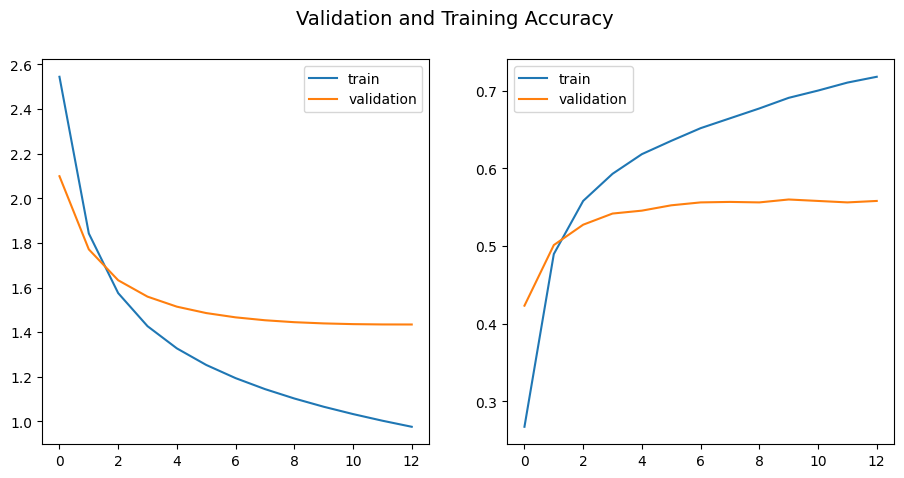

In [ ]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model.evaluate(X_train_scl2, y_train2, verbose=0)
_, test_acc = model.evaluate(X_test_scl2, y_test2, verbose=0)
print('Train accuracy: %.3f. Test accuracy : %.3f' % (train_acc, test_acc))

# ---- graficamos la función de perdida ----
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
# ---- graficamos la métrica de rendimiento ----
plt.subplot(1,2,2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()


##Predicciones

In [ ]:

predictions_matrix2 = model.predict(X_test_scl2)
predictions2 = np.argmax(predictions_matrix2, axis=1)
predictions2


89/89 [==============================] - 0s 2ms/step


array([ 6,  4,  4, ..., 10, 18, 19])

In [ ]:
y_testf2=np.argmax(y_test2, axis=1)
y_testf2

array([ 6,  4,  4, ..., 10, 18,  0])

##Métricas

Test Accuracy: 0.5631411390166254
Test Recall: 0.5644263265839717
Test Precision: 0.5515381049087509


<Figure size 30x30 with 0 Axes>

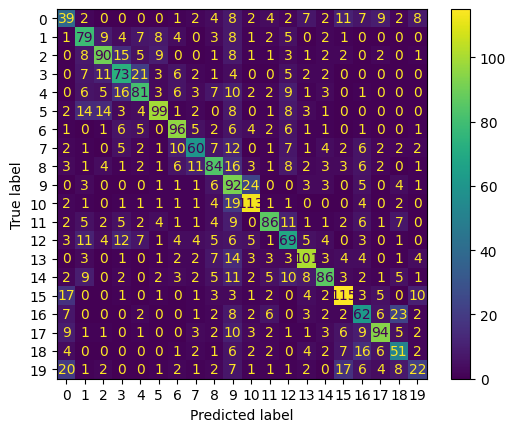

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Test Accuracy: {accuracy_score(predictions2, y_testf2)}")
print(f"Test Recall: {recall_score (predictions2, y_testf2,average='macro')}")
print(f"Test Precision: {precision_score(predictions2, y_testf2,average='macro')}")


plt.figure(figsize=(.3,.3))
#sns.heatmap(cm,cmap='plasma',annot=True)
cm_display = ConfusionMatrixDisplay(confusion_matrix =  confusion_matrix( y_testf2,predictions2))
cm_display.plot()
plt.show()

##Veamos el score ROC-AUC

In [ ]:
from sklearn.metrics import roc_auc_score

print(f"Shape de y_test: {y_test2.shape}")
print(f"Shape de las predicciones para el conjunto de prueba: {predictions_matrix2.shape}")

roc_auc_score(y_test2,predictions_matrix2)

Shape de y_test: (2827, 20)
Shape de las predicciones para el conjunto de prueba: (2827, 20)


0.9303939021763306




---


---


### **3.2 BOW**

---



---



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

topn_words = 800

count_vectorizer = CountVectorizer(stop_words='english',
                                    max_features=topn_words)
X_counts = count_vectorizer.fit_transform(clean_docs)
X_counts =  np.asarray(X_counts.todense())
print(X_counts.shape)

(18846, 800)


Diccionario que contiene el índice de cada palabra en el vocabulario

In [ ]:
count_vectorizer.vocabulary_

{'sure': 694,
 'fan': 244,
 'pretty': 534,
 'lack': 366,
 'kind': 362,
 'post': 527,
 'recent': 575,
 'actually': 7,
 'bite': 68,
 'end': 217,
 'man': 410,
 'kill': 361,
 'think': 720,
 'better': 64,
 'season': 623,
 'lot': 401,
 'watch': 767,
 'let': 379,
 'couple': 151,
 'game': 278,
 'beat': 59,
 'lose': 400,
 'final': 259,
 'rule': 607,
 'market': 414,
 'video': 754,
 'card': 88,
 'support': 692,
 'local': 395,
 'bus': 81,
 'mb': 420,
 'ram': 563,
 'graphics': 289,
 'email': 215,
 'thank': 713,
 'finally': 260,
 'say': 615,
 'new': 461,
 'area': 36,
 'years': 794,
 'like': 387,
 'number': 469,
 'usa': 745,
 'april': 34,
 'change': 98,
 'mention': 429,
 'true': 731,
 'shall': 637,
 'women': 782,
 'children': 103,
 'pay': 498,
 'price': 536,
 'armenians': 42,
 'forget': 269,
 'fight': 256,
 'time': 722,
 'lie': 384,
 'dont': 198,
 'person': 505,
 'shoot': 640,
 'thats': 714,
 'search': 622,
 'turkish': 735,
 'plan': 514,
 'know': 363,
 'talk': 700,
 'government': 287,
 'weapons': 771

Construimos un dataframe con la matriz de features

In [ ]:
X = pd.DataFrame(X_counts)

# Reordenamos las columnas, traemos la columna 'id' al principio
cols = X.columns.tolist()
cols = cols[:]
X= X[cols]

print(X.shape)
X.head()

(18846, 800)


,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Realizamos codificación a **'y'**  con "one-hot" encoding

In [ ]:
y

array([10,  3, 17, ...,  3,  1,  7])

In [ ]:
Y = pd.get_dummies(data=y)
Y


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18841,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
18842,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
18843,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18844,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X1=X.iloc[:,:].values
Y1=Y.iloc[:,:].values
print(X1.shape, Y1.shape)

(18846, 800) (18846, 20)


##División en conjuntos de entrenamiento y prueba

In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1,Y1,train_size=0.85,random_state=189)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 16019
Test size: 2827


##Reducción de dimensionalidad

In [ ]:
"""
from sklearn.feature_selection import SelectKBest, VarianceThreshold
selector = VarianceThreshold(0.25)
X_train1 = selector.fit_transform(X_train)
X_test1 = selector.transform(X_test)
"""

'\nfrom sklearn.feature_selection import SelectKBest, VarianceThreshold\nselector = VarianceThreshold(0.25)\nX_train1 = selector.fit_transform(X_train)\nX_test1 = selector.transform(X_test)\n'

##Normalizamos

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)


##Construcción del modelo

In [ ]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical


In [ ]:
##Sin dropout

model = Sequential()

model.add(Dense(1600, input_dim=800, activation='tanh'))
model.add(Dense(800, activation='tanh'))
model.add(Dense(20, activation='softmax'))

model.compile(loss='CategoricalCrossentropy', optimizer='adagrad', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train_scl, y_train, validation_split=0.1, epochs=13,verbose=1)

Epoch 1/13
451/451 [==============================] - 3s 4ms/step - loss: 2.7378 - accuracy: 0.1925 - val_loss: 2.3973 - val_accuracy: 0.3371
Epoch 2/13
451/451 [==============================] - 2s 4ms/step - loss: 2.2193 - accuracy: 0.3967 - val_loss: 2.0817 - val_accuracy: 0.4401
Epoch 3/13
451/451 [==============================] - 2s 5ms/step - loss: 1.9628 - accuracy: 0.4765 - val_loss: 1.9117 - val_accuracy: 0.4819
Epoch 4/13
451/451 [==============================] - 2s 5ms/step - loss: 1.8040 - accuracy: 0.5167 - val_loss: 1.8039 - val_accuracy: 0.5019
Epoch 5/13
451/451 [==============================] - 2s 5ms/step - loss: 1.6930 - accuracy: 0.5429 - val_loss: 1.7307 - val_accuracy: 0.5187
Epoch 6/13
451/451 [==============================] - 4s 8ms/step - loss: 1.6094 - accuracy: 0.5650 - val_loss: 1.6758 - val_accuracy: 0.5268
Epoch 7/13
451/451 [==============================] - 2s 4ms/step - loss: 1.5430 - accuracy: 0.5781 - val_loss: 1.6347 - val_accuracy: 0.5331
Epoch 

Train accuracy: 0.629. Test accuracy : 0.533


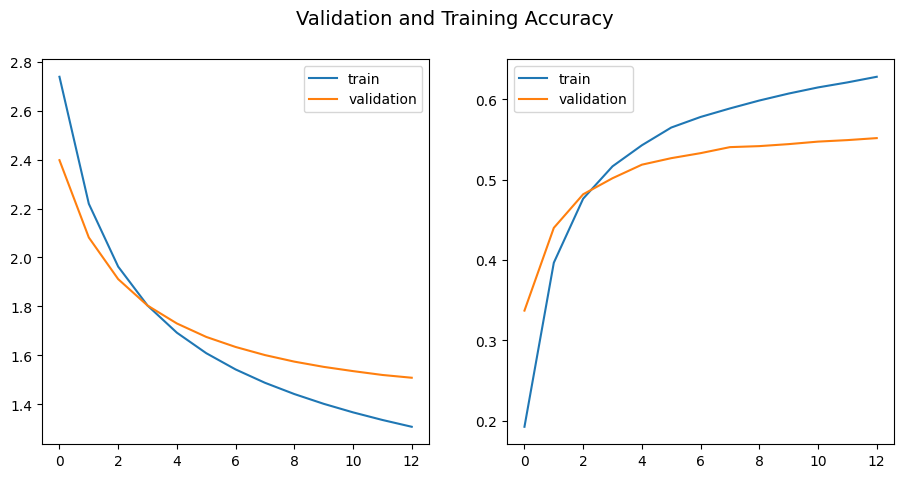

In [ ]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model.evaluate(X_train_scl, y_train, verbose=0)
_, test_acc = model.evaluate(X_test_scl, y_test, verbose=0)
print('Train accuracy: %.3f. Test accuracy : %.3f' % (train_acc, test_acc))

# ---- graficamos la función de perdida ----
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
# ---- graficamos la métrica de rendimiento ----
plt.subplot(1,2,2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()


##Predicciones

In [ ]:

predictions_matrix = model.predict(X_test_scl)
predictions = np.argmax(predictions_matrix, axis=1)
predictions


89/89 [==============================] - 0s 2ms/step


array([ 6,  4,  4, ..., 10,  0, 16])

In [ ]:
y_testf=np.argmax(y_test, axis=1)
y_testf

array([ 6,  4,  4, ..., 10, 18,  0])

##Métricas

Test Accuracy: 0.5327201980898479
Test Recall: 0.5426834616058125
Test Precision: 0.521211321104264


<Figure size 30x30 with 0 Axes>

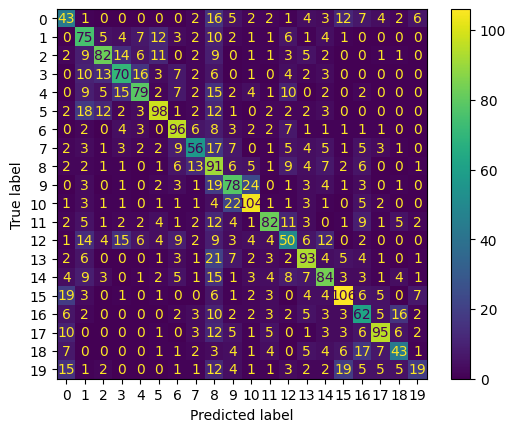

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Test Accuracy: {accuracy_score(predictions, y_testf)}")
print(f"Test Recall: {recall_score (predictions, y_testf,average='macro')}")
print(f"Test Precision: {precision_score(predictions, y_testf,average='macro')}")


plt.figure(figsize=(.3,.3))
#sns.heatmap(cm,cmap='plasma',annot=True)
cm_display = ConfusionMatrixDisplay(confusion_matrix =  confusion_matrix( y_testf,predictions))
cm_display.plot()
plt.show()

##Veamos el score ROC-AUC

In [ ]:
from sklearn.metrics import roc_auc_score

print(f"Shape de y_test: {y_test.shape}")
print(f"Shape de las predicciones para el conjunto de prueba: {predictions_matrix.shape}")

roc_auc_score(y_test,predictions_matrix)

Shape de y_test: (2827, 20)
Shape de las predicciones para el conjunto de prueba: (2827, 20)


0.9206053871694015

##Conclusiones

En ambas estrategias para obtener las features, no se realizó reducción de dimensionalidad, para la normalización se utilizó EstandaScaler con un split de 85% de entrenamiento y 15% de prueba.\
Resultados con el modelo:\
>**model.add(Dense(1600, input_dim=800, activation='tanh'))**\
**model.add(Dense(800, activation='tanh'))**\
**model.add(Dense(20, activation='softmax'))**\

**model.compile(loss='CategoricalCrossentropy', optimizer='adagrad', metrics=['accuracy'])**\

Considerando 13 épocas. SIN DROP OUT

\begin{array}{| c  c  c |}
 \hline
& TF-IDF & BOW  \\ \hline
Accuracy  & 0.5578351609480015 &  0.5298903431199151 \\
Recall & 0.5579493548542505 & 0.532404501836082 \\
Precision & 0.5476987917381034 & 0.5181985162651495 \\
ROC AUC & 0.930138218859701&  0.9201288306661469 \\ \hline
\end{array}



##Veamos si mejora el módelo con un gridsearch

In [ ]:
from keras.models import Sequential
from keras.layers import Dense


def create_model(n_neurons,activation):
  model = Sequential()
  model.add(Dense(n_neurons, input_dim=800, activation=activation))
  model.add(Dense(800, activation='tanh'))
  model.add(Dense(20,activation='softmax'))
  model.compile(loss='CategoricalCrossentropy', optimizer='adagrad', metrics=['accuracy'])
  return model



In [ ]:
!pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=3) #patience es cada cuando tiene que hacer el cambio si no hay mejoras

model = KerasClassifier(
    create_model,
    n_neurons=800,
    activation='sigmoid',
    epochs=15,
    verbose=1,
    callbacks=[es],
    validation_split=0.1
)


In [ ]:
from sklearn.model_selection import GridSearchCV

# ----- Definimos los parámetros de la busqueda -----
neurons = [400,800,1600]
activations = ['softmax','sigmoid','tanh']
param_grid = {'n_neurons':neurons,
              'activation':activations}

# ----- Definimos y realizamos el gridsearch
gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = gs.fit(X_train_scl, y_train)
grid_result

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/15
451/451 [==============================] - 3s 4ms/step - loss: 2.7052 - accuracy: 0.2024 - val_loss: 2.3618 - val_accuracy: 0.3645
Epoch 2/15
451/451 [==============================] - 2s 5ms/step - loss: 2.2012 - accuracy: 0.4045 - val_loss: 2.0550 - val_accuracy: 0.4569
Epoch 3/15
451/451 [==============================] - 2s 5ms/step - loss: 1.9507 - accuracy: 0.4787 - val_loss: 1.8892 - val_accuracy: 0.4850
Epoch 4/15
451/451 [==============================] - 2s 4ms/step - loss: 1.7955 - accuracy: 0.5181 - val_loss: 1.7855 - val_accuracy: 0.5075
Epoch 5/15
451/451 [==============================] - 2s 4ms/step - loss: 1.6871 - accuracy: 0.5408 - val_loss: 1.7148 - val_accuracy: 0.5125
Epoch 6/15
451/451 [==============================] - 2s 4ms/step - loss: 1.6052 - accuracy: 0.5592 - val_loss: 1.6618 - val_accuracy: 0.5243
Epoch 7/15
451/451 [==============================] - 2s 4ms/step - loss: 1.5401 - accuracy: 0.5758 - val_loss: 1.6221 - val_accuracy: 0.5256
Epoch 

GridSearchCV(cv=3,
             estimator=KerasClassifier(activation='sigmoid', callbacks=[<keras.callbacks.EarlyStopping object at 0x7fa496616c80>], epochs=15, model=<function create_model at 0x7fa4966779a0>, n_neurons=800, validation_split=0.1),
             n_jobs=-1,
             param_grid={'activation': ['softmax', 'sigmoid', 'tanh'],
                         'n_neurons': [400, 800, 1600]})

In [ ]:
print(f"Best Accuracy: {grid_result.best_score_} using parameters {grid_result.best_params_}")

Best Accuracy: 0.5052747209834869 using parameters {'activation': 'tanh', 'n_neurons': 1600}
